## Author: Maryam Khanahmadi - Computational physicist - Postdoc at Chalmers University of technology
## Email: m.khanahmadi94@gmail.com

#### This code explores encoder-decoder architecture to apply the sequence to sequence learning and utilizing HPO

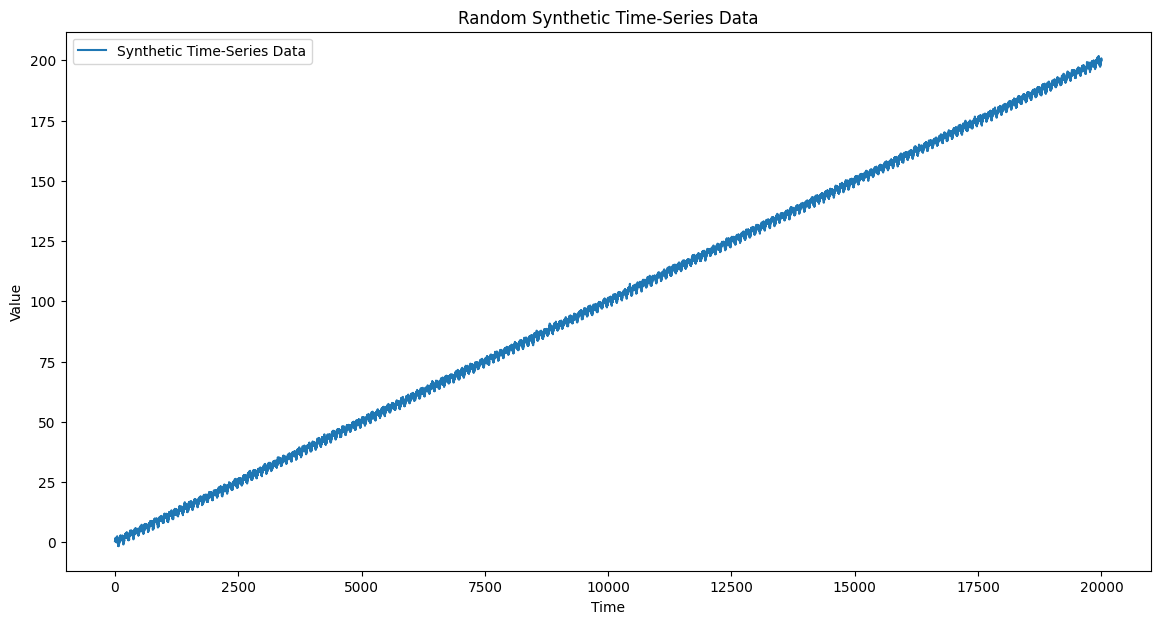

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_points = 20000  # Number of data points
period = 100        # Period of the sine wave
trend_slope = 0.01  # Trend slope
noise_std = 0.5     # Standard deviation of noise

# Generate time points
time = np.arange(num_points)

# Generate synthetic data components
trend = trend_slope * time
seasonality = 1.0 * np.sin(2 * np.pi * time / period)  # Sine wave for seasonality
seasonality += 0.5 * np.cos(4 * np.pi * time / period)  # Additional cosine wave for more complexity
noise = np.random.normal(0, noise_std, num_points)  # Add random noise

# Create the time series data
data = trend + seasonality + noise

# Plot the synthetic data
plt.figure(figsize=(14, 7))
plt.plot(time, data, label='Synthetic Time-Series Data')
plt.title('Random Synthetic Time-Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Reshape the data
data = data.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Create sequences for Encoder-Decoder LSTM
def create_sequences(data, input_sequence_length=30, output_sequence_length=10):
    X, y = [], []
    for i in range(len(data) - input_sequence_length - output_sequence_length):
        X.append(data[i:i + input_sequence_length])
        y.append(data[i + input_sequence_length:i + input_sequence_length + output_sequence_length])
    return np.array(X), np.array(y)

input_sequence_length = 30
output_sequence_length = 10
X, y = create_sequences(data_normalized, input_sequence_length=input_sequence_length, output_sequence_length=output_sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (13972, 30, 1)
y_train shape: (13972, 10, 1)
X_test shape: (5988, 30, 1)
y_test shape: (5988, 10, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import keras_tuner as kt
import tempfile

# Define the encoder-decoder LSTM model
def build_encoder_decoder_model(input_sequence_length, output_sequence_length, hp):
    inputs = Input(shape=(input_sequence_length, 1))
    encoder = LSTM(units=hp.Int('units_encoder', min_value=50, max_value=200, step=50), activation='relu')(inputs)
    encoder = RepeatVector(output_sequence_length)(encoder)
    decoder = LSTM(units=hp.Int('units_decoder', min_value=50, max_value=200, step=50), activation='relu', return_sequences=True)(encoder)
    outputs = TimeDistributed(Dense(1))(decoder)
    model = Model(inputs, outputs)
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']), loss='mean_squared_error')
    return model

# Initialize KerasTuner with a temporary directory
with tempfile.TemporaryDirectory() as tmpdirname:
    tuner = kt.RandomSearch(
        lambda hp: build_encoder_decoder_model(input_sequence_length, output_sequence_length, hp),
        objective='val_loss',
        max_trials=2,
        executions_per_trial=1,
        directory=tmpdirname,
        project_name='encoder_decoder_lstm'
    )

    # Define early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Search for the best hyperparameters
    tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]

    # Train the best model on the full training data
    history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])

# Evaluate the model
loss = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')


Trial 2 Complete [00h 05m 25s]
val_loss: 3.06561378238257e-05

Best val_loss So Far: 2.5806988560361788e-05
Total elapsed time: 00h 06m 43s


/Users/maryamkhanahmadi/maryamenv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4978e-05
Test Loss: 0.0000


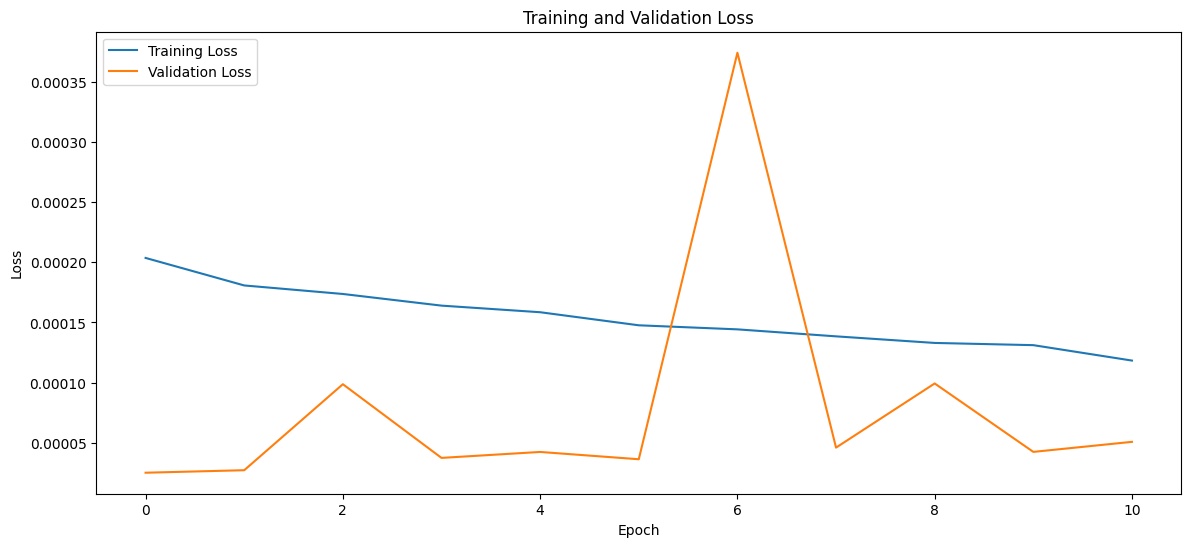

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
